# Imports

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

# Bring in the data

In [61]:
colnames=['timestamp', 'times', 'request_agent', "unk1", "unk2", "ip"]

In [62]:
df_orig = pd.read_csv("curriculum-access.txt",
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"')

In [63]:
df_orig.head()

,timestamp,times,request_agent,unk1,unk2,ip
0,2018-01-26,09:55:03,/,1,8.0,98.106.20.62
1,2018-01-26,09:56:02,java-ii,1,8.0,98.106.20.62
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,98.106.20.62
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62


In [64]:
df_orig.shape

(543596, 6)

In [65]:
df_orig.unk1.value_counts()

11     11065
64     10784
53      9534
1       5437
344     5370
       ...  
593        1
592        1
649        1
66         1
163        1
Name: unk1, Length: 650, dtype: int64

In [66]:
df_orig.unk2.value_counts()

33.0    38851
28.0    37409
29.0    36613
24.0    35336
53.0    29992
22.0    28997
23.0    28193
32.0    27920
26.0    27586
51.0    26389
52.0    26212
25.0    25364
31.0    24322
34.0    23845
27.0    20264
56.0    14438
55.0    14252
57.0     9547
14.0     9374
1.0      8882
21.0     7411
17.0     4821
13.0     2626
8.0      1712
18.0     1641
19.0     1165
16.0      743
15.0      691
7.0       495
12.0      270
11.0      204
2.0        93
6.0        72
9.0         5
4.0         4
5.0         1
Name: unk2, dtype: int64

In [67]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543596 entries, 0 to 543595
Data columns (total 6 columns):
timestamp        543596 non-null object
times            543596 non-null object
request_agent    543595 non-null object
unk1             543596 non-null int64
unk2             515740 non-null float64
ip               543596 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 24.9+ MB


In [68]:
df_orig["Timestamp"] = df_orig["timestamp"] + " " + df_orig["times"]

In [69]:
df_orig = df_orig.drop(columns = ['timestamp', 'times'])

In [70]:
df_orig['Timestamp'] = pd.to_datetime(df_orig['Timestamp'])

In [71]:
df_orig = df_orig.sort_values("Timestamp").set_index("Timestamp")

In [72]:
df_orig

,request_agent,unk1,unk2,ip
Timestamp,,,,
2018-01-26 09:55:03,/,1,8.0,98.106.20.62
2018-01-26 09:56:02,java-ii,1,8.0,98.106.20.62
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,98.106.20.62
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62
...,...,...,...,...
2020-05-15 15:01:40,java-ii/file-io,602,56.0,48.188.241.68
2020-05-15 15:01:54,9-timeseries/3-prep,582,55.0,48.135.163.38
2020-05-15 15:03:37,jquery/ajax/requests-and-responses,637,57.0,71.121.18.17


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12da8a9d0>,
      dtype=object)

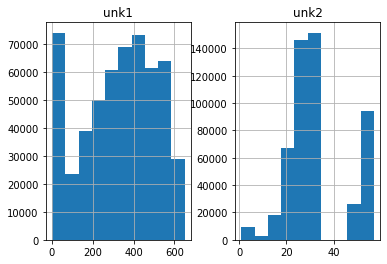

In [73]:
df_orig.hist()

In [81]:
df_orig.request_agent.value_counts()

/                                           28920
javascript-i                                10950
search/search_index.json                    10859
toc                                          9839
html-css                                     8202
                                            ...  
115                                             1
130                                             1
content/mysql/clauses/order-by.html             1
html                                            1
jquery/ajax/requests-and-responses/.json        1
Name: request_agent, Length: 1811, dtype: int64

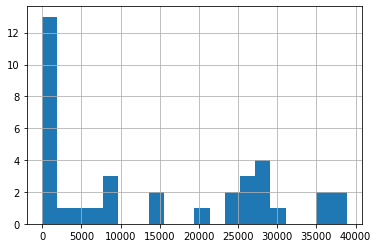

In [84]:
df_orig.unk2.value_counts().hist(bins=20)

# Detecting Anomalies in Discrete Variables

In [85]:
ip_df = pd.DataFrame(df_orig.ip.value_counts(dropna=False)).reset_index().rename(index=str, columns={"index": "ip", "ip": "ip_count"})

In [87]:
ip_df.head()

,ip,ip_count
0,98.106.20.59,284579
1,98.106.20.62,61662
2,193.172.118.211,9029
3,13.107.209.195,4219
4,173.125.68.94,2980


In [88]:
ip_df2 = pd.DataFrame(df_orig.ip.value_counts(dropna=False)/df_orig.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

In [90]:
ip_df2.head()

,ip,ip_proba
0,98.106.20.59,0.523512
1,98.106.20.62,0.113434
2,193.172.118.211,0.016610
3,13.107.209.195,0.007761
4,173.125.68.94,0.005482


In [91]:
ip_df = ip_df.merge(ip_df2)

In [92]:
ip_df.head()

,ip,ip_count,ip_proba
0,98.106.20.59,284579,0.523512
1,98.106.20.62,61662,0.113434
2,193.172.118.211,9029,0.016610
3,13.107.209.195,4219,0.007761
4,173.125.68.94,2980,0.005482


In [104]:
# see those where rate < 1% 
ip_df[ip_df.ip_count < 2]

,ip,ip_count,ip_proba
2972,71.118.60.31,1,0.000002
2973,104.209.221.138,1,0.000002
2974,105.177.92.162,1,0.000002
2975,174.240.233.112,1,0.000002
2976,108.78.219.168,1,0.000002
...,...,...,...
3490,185.204.16.96,1,0.000002
3491,173.59.111.172,1,0.000002
3492,65.251.5.126,1,0.000002
3493,173.59.68.141,1,0.000002


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13f7e6dd0>,
      dtype=object)

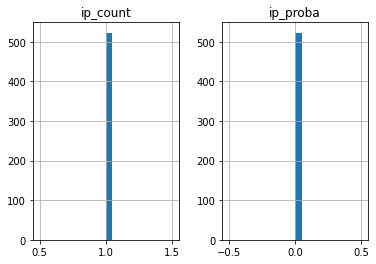

In [114]:
ip_df[ip_df.ip_count == 1].hist(bins=20)

In [119]:
df_orig[df_orig.request_agent.isnull()]

,request_agent,unk1,unk2,ip
Timestamp,,,,
2020-04-08 09:25:18,NaN,586,55.0,73.178.241.52


In [141]:
plt.figure(figsize=(13,10))
df_orig.groupby("unk1").ip.count()

unk1
1      5437
2      1541
3      1562
4       692
5      1701
       ... 
646      41
647      10
648     488
649       1
650       2
Name: ip, Length: 650, dtype: int64

<Figure size 936x720 with 0 Axes>

In [151]:
df_orig.groupby("unk2").ip.nunique()

unk2
1.0      46
2.0       6
4.0       1
5.0       1
6.0      12
7.0      27
8.0      14
9.0       1
11.0     12
12.0      7
13.0     36
14.0     32
15.0      9
16.0     18
17.0     70
18.0     41
19.0     60
21.0    180
22.0    210
23.0    220
24.0    154
25.0    406
26.0    141
27.0    170
28.0    173
29.0    223
31.0    142
32.0    112
33.0    215
34.0    192
51.0    150
52.0    272
53.0    117
55.0    212
56.0     42
57.0     52
Name: ip, dtype: int64

In [152]:
df_orig.ip.value_counts()

98.106.20.59       284579
98.106.20.62        61662
193.172.118.211      9029
13.107.209.195       4219
173.125.68.94        2980
                    ...  
185.204.16.96           1
173.59.111.172          1
65.251.5.126            1
173.59.68.141           1
173.125.67.236          1
Name: ip, Length: 3495, dtype: int64

In [160]:
not_codeup_ip = df_orig[df_orig.ip != "98.106.20.59"]

In [161]:
not_codeup_ip = not_codeup_ip[not_codeup_ip.ip != "98.106.20.62"]

In [162]:
not_codeup_ip

,request_agent,unk1,unk2,ip
Timestamp,,,,
2018-01-26 10:59:02,index.html,21,16.0,72.138.147.72
2018-01-26 10:59:06,java-i,21,16.0,72.138.147.72
2018-01-26 12:20:36,javascript-i/javascript-with-html,34,22.0,210.206.124.243
2018-01-26 12:20:41,javascript-i/functions,34,22.0,210.206.124.243
2018-01-26 12:37:53,/,37,19.0,193.172.118.211
...,...,...,...,...
2020-05-15 15:01:40,java-ii/file-io,602,56.0,48.188.241.68
2020-05-15 15:01:54,9-timeseries/3-prep,582,55.0,48.135.163.38
2020-05-15 15:03:37,jquery/ajax/requests-and-responses,637,57.0,71.121.18.17


In [164]:
not_codeup_ip.ip.value_counts() 

193.172.118.211    9029
13.107.209.195     4219
173.125.68.94      2980
77.186.132.227     1826
137.51.33.152      1788
                   ... 
100.204.27.220        1
108.78.220.35         1
100.204.28.190        1
185.204.6.1           1
175.256.149.29        1
Name: ip, Length: 3493, dtype: int64

In [185]:
not_codeup_ip["Day"] = not_codeup_ip.index.weekday_name

In [186]:
not_codeup_ip

,request_agent,unk1,unk2,ip,Day
Timestamp,,,,,
2018-01-26 10:59:02,index.html,21,16.0,72.138.147.72,Friday
2018-01-26 10:59:06,java-i,21,16.0,72.138.147.72,Friday
2018-01-26 12:20:36,javascript-i/javascript-with-html,34,22.0,210.206.124.243,Friday
2018-01-26 12:20:41,javascript-i/functions,34,22.0,210.206.124.243,Friday
2018-01-26 12:37:53,/,37,19.0,193.172.118.211,Friday
...,...,...,...,...,...
2020-05-15 15:01:40,java-ii/file-io,602,56.0,48.188.241.68,Friday
2020-05-15 15:01:54,9-timeseries/3-prep,582,55.0,48.135.163.38,Friday
2020-05-15 15:03:37,jquery/ajax/requests-and-responses,637,57.0,71.121.18.17,Friday


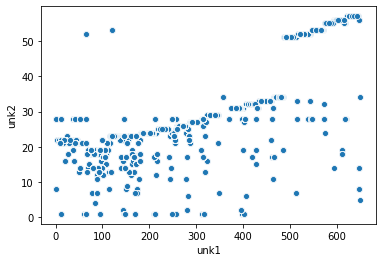

In [193]:
sns.scatterplot(not_codeup_ip.unk1, not_codeup_ip.unk2)

- Can you label students who are viewing both the web dev and data science curriculum?
- Can you label students by the program they are in? Can you label users by student vs. staff? 
- What are Zach, Maggie, David, and Ryan's ids?

In [206]:
df_orig.groupby(["unk2", "unk1"]).request_agent.value_counts()

unk2  unk1  request_agent                      
1.0   11    /                                      237
            javascript-i                           150
            html-css                               104
            java-ii                                 85
            javascript-ii                           84
                                                  ... 
57.0  645   java-i/control-statements-and-loops      1
            javascript-ii                            1
            jquery/ajax                              1
            jquery/essential-methods/traversing      1
            jquery/events/keyboard-events            1
Name: request_agent, Length: 72039, dtype: int64

In [208]:
pd.crosstab(df_orig.request_agent, df_orig.unk2)

unk2,1.0,2.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,12.0,...,31.0,32.0,33.0,34.0,51.0,52.0,53.0,55.0,56.0,57.0
request_agent,,,,,,,,,,,,,,,,,,,,,
%20https://github.com/RaulCPena,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
",%20https://github.com/RaulCPena",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
.git,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.gitignore,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/,620,17,1,1,4,34,210,1,6,7,...,1040,823,1543,1681,1041,1052,1457,865,591,647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
web-design/ux/layout,0,0,0,0,0,0,0,0,0,0,...,6,38,34,0,12,32,18,0,14,8
web-design/ux/layout/.json,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
web-design/ux/purpose,0,0,0,0,0,0,0,0,0,0,...,8,32,28,0,9,27,12,0,18,8


In [211]:
curie = df_orig[df_orig.unk2 == 55]

In [212]:
curie

,request_agent,unk1,unk2,ip
Timestamp,,,,
2020-02-03 15:39:34,login,575,55.0,98.106.20.59
2020-02-03 15:39:35,/,576,55.0,98.106.20.59
2020-02-03 15:39:37,/,577,55.0,98.106.20.59
2020-02-03 15:39:37,login,575,55.0,98.106.20.59
2020-02-03 15:39:43,/,578,55.0,98.106.20.59
...,...,...,...,...
2020-05-15 14:46:46,search/search_index.json,591,55.0,174.176.101.202
2020-05-15 14:47:01,appendix/professional-development/t-block-less...,591,55.0,174.176.101.202
2020-05-15 14:49:50,appendix/professional-development/vertical-resume,591,55.0,174.176.101.202


In [214]:
curie.unk1.value_counts()

581    1767
576    1323
580    1146
590    1020
584    1011
582     933
579     893
585     759
586     683
591     668
578     600
587     576
589     570
588     525
617     405
616     388
583     373
575     344
577     268
Name: unk1, dtype: int64

In [ ]:
df.unk1()